# Gray Image Segmentation 

In [2]:
# import statements 
import numpy as np
import matplotlib.pyplot as plt 
from skimage.transform import resize

In [2]:
def anti_aliasing_resize(img):
    """This function can be used for resizing images of huge size to optimize the segmentation algorithm"""
    ratio = min(1, np.sqrt((512*512) / np.prod(img.shape[:2])))
    newshape = list(map( lambda d : int(round(d*ratio)), img.shape[:2])) 
    img = resize( img, newshape , anti_aliasing = True )
    return img

def convert_to_grayscale(image):
    if len(image.shape) == 3: 
        return  np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    return image

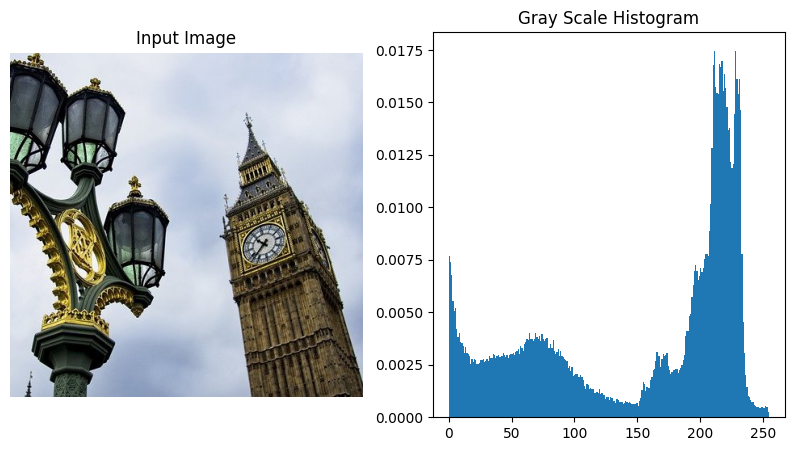

In [3]:
fig_1, ax_1 = plt.subplots(1,2,figsize = (10,5))
test_image_1 = plt.imread("../test_images/elizabeth_tower_london.jpg")
ax_1[0].imshow(test_image_1)
ax_1[0].axis("off");
ax_1[0].set_title("Input Image")
ax_1[1].hist(convert_to_grayscale(test_image_1).flatten(), 256, density = True);
ax_1[1].set_title("Gray Scale Histogram");

## Optimal Thresholding

In [4]:
def optimal_th(image):
    bg_sum = image[0,0] + image[-1,0] + image[-1,-1] + image[0,-1]  # first assumption, the background is the corners. 
    fg_sum = np.sum(np.sum(image, axis=0)) - bg_sum
    bg_mean = bg_sum / 4 
    fg_mean = fg_sum / (np.size(image) - 4) # size returns the entire number of pixles 
    th_prev = (bg_mean + fg_mean) / 2 
    while True:
        bg_mean = np.mean(image[image < th_prev])
        fg_mean = np.mean(image[image >= th_prev]) 
        curr_th =  (bg_mean + fg_mean) / 2 
        if curr_th == th_prev: # convergence 
            return curr_th
        else: # otherwise update and keep going. 
            th_prev = curr_th

In [5]:
gray_scaled_image = convert_to_grayscale(test_image_1)  
th = optimal_th(gray_scaled_image) 

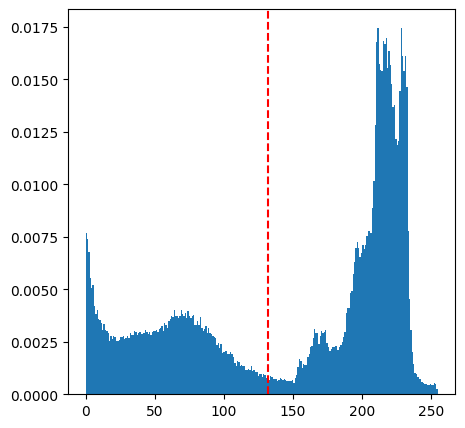

In [6]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
magnitude = ax.hist(gray_scaled_image.flatten(), 256, density = True)
ax.axvline(x=th, color='r', linestyle='--'); # very good seperation 

In [7]:
def apply_optimal_threshodling(image):
    image = convert_to_grayscale(image)
    image = anti_aliasing_resize(image)
    th = optimal_th(image)
    print(th) # fractional not in range (0,255)
    fig, ax = plt.subplots(figsize = (7,7))
    ax.imshow(image >= th, cmap="gray")
    ax.axis("off")

132.0084437378241


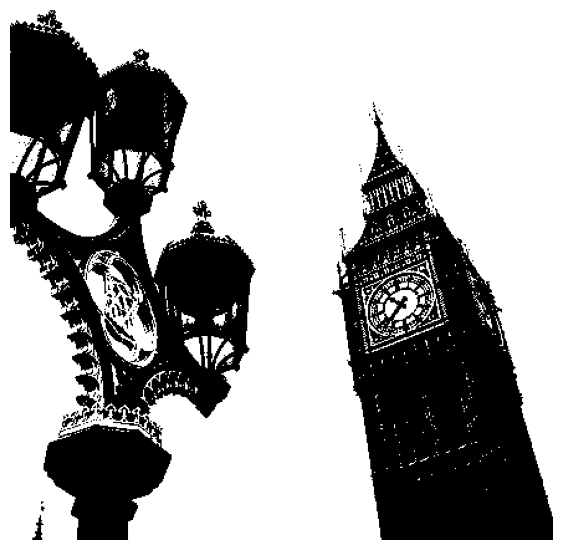

In [8]:
apply_optimal_threshodling(test_image_1)

## Otsu's Thresholding (Using In-between Variance Maximization Criteria)

In [9]:
def otsu_th(image): # takes colored image 
    mapped_image = ((image - image.min())*(1/(image.max() - image.min()))*255).astype(np.uint8) # map up 

    hist_lookup = np.array([np.sum(mapped_image == i) for i in range(256)])  * 1/ np.size(image) 
    in_between_var = (0,-np.inf) # assumption (best_intensity, max_value) 

    for candidate_th in range(256):
        w_0 = np.sum(hist_lookup[:candidate_th]) 
        w_1 = np.sum(hist_lookup[candidate_th:]) 

        if w_0 == 0 or w_1 == 0:
            continue
        
        mu_0 = np.sum(np.array([i * hist_lookup[i] for i in range(0,candidate_th)])) * 1/w_0
        mu_1 = np.sum(np.array([i * hist_lookup[i] for i in range(candidate_th, 256)])) * 1/w_1

        curr_result = w_0 * w_1 * (mu_0 - mu_1) ** 2

        if curr_result > in_between_var[1]:
            in_between_var = (candidate_th,curr_result)

    th = (in_between_var[0]/255)*(image.max()-image.min()) + image.min() # map down 

    return th  


In [10]:
def apply_otsu_threshodling(image):
    image = convert_to_grayscale(image)
    image = anti_aliasing_resize(image)
    th = otsu_th(image)
    print(th) # fractional threshold value. 
    fig, ax = plt.subplots(figsize = (7,7))
    ax.imshow(image >= th, cmap="gray")
    ax.axis("off") 

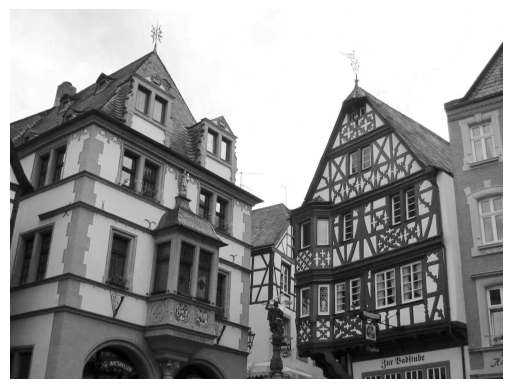

In [3]:
test_image_2 = plt.imread("../test_images/image_processing_pre_otsus_algorithm.jpg");
plt.imshow(test_image_2, cmap="gray")
plt.axis("off");

0.6039643145626001


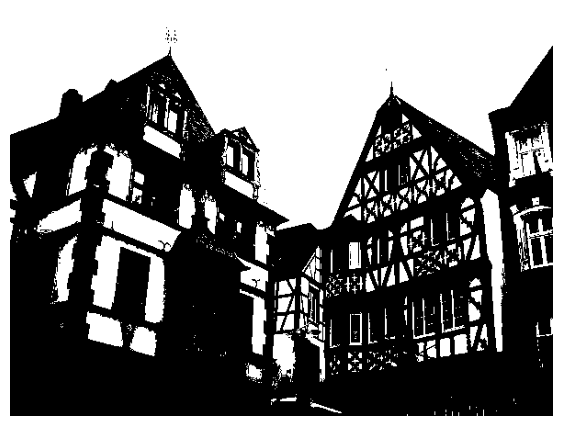

In [12]:
apply_otsu_threshodling(test_image_2);